In [ ]:
import glob
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from scipy.signal import butter, filtfilt, find_peaks
from skimage.transform import resize
import datetime

CONFIG = {
    'target_files': [
        'train_data/091222.npy', 
        'train_data/090532.npy',
        'train_data/092722.npy',
    ],
    
    'dx': 5.106500953873407,
    'dt': 0.0016,
    
    'img_shape': (400, 400),
    'bands': [(10, 215)],

    # 'bands': [(10, 15), (40, 60), (80, 95), (100, 120), (160, 180), (198, 215)],

    'hough_params': {
        'rho': 1, 
        'theta': np.pi/180, 
        'threshold': 80, 
        'minLineLength': 300, 
        'maxLineGap': 75
    },

    'merge_params': {
        'angle_thresh': 0.1,
        'center_thresh': 30,
    }
}

In [ ]:
def load_data(dir: str = 'train_data/') -> list[str]:
    files = glob.glob(dir+"*")
    files.sort()
    return files


def find_id_by_filename(starting_fname: str, files: list[str]) -> int | None:
    first_id = None
    for idx, fname in enumerate(files):
        if fname == starting_fname:
            first_id = idx
    return first_id


def retrieve_sensor_data(fname: str, files: list[str], dx: float = 5.106500953873407, dt: float = 0.0016) -> np.ndarray:
    starting_file_id = find_id_by_filename(fname, files)
    if starting_file_id is None:
        return None
    data = []
    for file in files[starting_file_id:starting_file_id+12]:
        data.append(np.load(file))
    data = np.concatenate(data).astype(np.float32)

    time_start = datetime.datetime.strptime(
        '2024-05-07 ' + fname.split("/")[-1].split(".")[0], "%Y-%m-%d %H%M%S")
    index = pd.date_range(start=time_start, periods=len(data), freq=f'{dt}s')

    columns = np.arange(len(data[0])) * dx
    return pd.DataFrame(data, index=index, columns=columns)


def plot_fft(df, col_id, dt, xlim=300, ax=None):
    """Plot FFT spectrum at a spatial position on a specific axis."""
    if ax is None:
        ax = plt.gca()

    spatial_pos = df.columns[col_id]
    signal = df[spatial_pos].values
    fft_result = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(len(signal), d=dt)
    pos_freqs = fft_freqs[:len(signal)//2]
    pos_mags = np.abs(fft_result[:len(signal)//2])

    ax.plot(pos_freqs, pos_mags)
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Amplitude')
    ax.set_title(f'Spectrum at {spatial_pos:.1f} m')
    ax.set_xlim(0, xlim)
    ax.set_xticks(np.arange(0, xlim+10, 10)) # Optional cleanup


def plot_average_freq_spectrum(filtered_df, dt, col_start=None, col_end=None, ax=None):
    """Plots the average frequency spectrum on a specific axis."""
    if ax is None:
        ax = plt.gca()

    avg_signal = filtered_df.iloc[:, col_start:col_end].mean(axis=1).values
    fft_result = np.fft.fft(avg_signal)
    fft_freqs = np.fft.fftfreq(len(avg_signal), d=dt)
    positive_freqs = fft_freqs[:len(avg_signal)//2]
    positive_mags = np.abs(fft_result[:len(avg_signal)//2])

    ax.plot(positive_freqs, positive_mags, color='orange')
    ax.set_xlabel("Frequency [Hz]")
    ax.set_ylabel("Amplitude")
    title_substring = "all" if col_start is None else f"{col_start}-{col_end}"
    ax.set_title(f"Avg Spectrum ({title_substring})")

# https://www.geeksforgeeks.org/data-science/signal-filtering-with-scipy/


def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)


def filter_df_band(df, low, high, dt, order=4):
    fs = 1 / dt
    return df.apply(lambda col: butter_bandpass_filter(col.values, low, high, fs, order), axis=0)

def apply_band_filters(df, bands, dt, order=4):
    """
    Filter a DataFrame so that only the given bands are present (sum their filters).
    bands: list of (low, high) frequency tuples
    Returns: a DataFrame containing the sum of all filtered bands.
    """
    fs = 1 / dt
    result = np.zeros_like(df.to_numpy())
    for low, high in bands:
        filtered = df.apply(lambda col: butter_bandpass_filter(
            col.values, low, high, fs, order), axis=0)
        result += filtered.to_numpy()
    return pd.DataFrame(result, index=df.index, columns=df.columns)


def preprocess_df(df: pd.DataFrame) -> pd.DataFrame:
    data = df.to_numpy(dtype=np.float32)
    data = cv2.normalize(data, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    new_shape = (400, 400)
    start = df.index[0]
    end = df.index[-1]
    new_times = pd.date_range(start, end, periods=new_shape[0])
    data = resize(data, new_shape, anti_aliasing=True)
    data = cv2.normalize(data, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    processed_df = pd.DataFrame(data, index=new_times)
    return processed_df


def find_edges(df: pd.DataFrame) -> pd.DataFrame:
    data = df.to_numpy(dtype=np.uint8)
    bins = np.array([0, 4, 16, 32, 64, 128, 192, 256])
    quantized = np.digitize(data, bins) - 1
    quantized_img = quantized * (255 // (len(bins) - 1))

    return quantized_img.astype(np.uint8)


def plot_hough_lines(img, lines, speed_arr, norm, title="", ax=None):
    ax.imshow(img, cmap='viridis', aspect='auto', norm=norm)
    if lines is not None and speed_arr is not None:
        for line, speed in zip(lines, speed_arr):
            x1, y1, x2, y2 = line
            ax.plot([x1, x2], [y1, y2], color='r', linewidth=1)
            xm, ym = (x1 + x2) / 4, (y1 + y2) / 2
            ax.text(xm, ym, f"{speed:.1f} km/h", color='yellow', fontsize=8, va='center',
                    ha='center', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
    ax.set_title(title)
    ax.axis('off')


def filter_vertical_lines(lines, angle_threshold=10):
    """
    Remove lines within angle_threshold of vertical (90 deg).
    angle_threshold: degrees from 90 to consider "vertical".
    """
    result = []
    for x1, y1, x2, y2 in lines:
        dx = x2 - x1
        dy = y2 - y1
        if dx == 0:
            angle = 90
        else:
            angle = np.degrees(np.arctan2(dy, dx))
        # Consider vertical if angle is close to 90 or -90
        if not (90-angle_threshold <= abs(angle) <= 90+angle_threshold):
            result.append((x1, y1, x2, y2))
    return result


def line_angle(line):
    x1, y1, x2, y2 = line
    return np.arctan2(y2 - y1, x2 - x1)


def line_center(line):
    x1, y1, x2, y2 = line
    return ((x1 + x2)/2, (y1 + y2)/2)


def merge_lines(lines, angle_thresh=0.1, center_thresh=30):
    if lines is None or len(lines) == 0:
        return np.array([])

    used = [False] * len(lines)
    clusters = []

    for i, line in enumerate(lines):
        if used[i]:
            continue
        group = [line]
        a1 = line_angle(line)
        c1 = line_center(line)
        used[i] = True
        for j in range(i + 1, len(lines)):
            if used[j]:
                continue
            a2 = line_angle(lines[j])
            c2 = line_center(lines[j])
            if abs(a1 - a2) < angle_thresh and np.linalg.norm(np.array(c1) - np.array(c2)) < center_thresh:
                group.append(lines[j])
                used[j] = True
        clusters.append(group)

    merged = []
    for group in clusters:
        angles = [line_angle(l) for l in group]
        centers = [line_center(l) for l in group]
        # Average center
        cx, cy = np.mean(centers, axis=0)
        # Average angle
        angle = np.mean(angles)
        lengths = [np.linalg.norm([l[2]-l[0], l[3]-l[1]]) for l in group]
        L = np.mean(lengths)

        # Construct merged line endpoints
        dx = np.cos(angle) * L / 2
        dy = np.sin(angle) * L / 2
        x1, y1 = cx - dx, cy - dy
        x2, y2 = cx + dx, cy + dy
        merged.append([x1, y1, x2, y2])
    return np.array(merged)


def calculate_speed(lines: np.ndarray, dx: float, dt: float) -> np.ndarray:
    speeds = []
    for x1, y1, x2, y2 in lines:
        t1_idx = y1 * (75000 / 400)
        t2_idx = y2 * (75000 / 400)
        d1_idx = x1 * (52 / 400)
        d2_idx = x2 * (52 / 400)
        t1 = t1_idx * dt
        t2 = t2_idx * dt
        d1 = d1_idx * dx
        d2 = d2_idx * dx
        delta_d = d2 - d1
        delta_t = t2 - t1
        speed = delta_d / delta_t if delta_t != 0 else np.nan
        speeds.append(np.abs(speed*3600/1000))
    # print(speeds)

    return np.array(speeds)


def compare_hough_parameters(
    img,
    norm,
    edges,
    thresholds=[20, 30, 50, 80],
    min_lengths=[60, 120, 180, 240],
    max_gaps=[10, 25, 50, 75]
):
    nrows = len(thresholds)
    ncols = len(min_lengths) * len(max_gaps)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows))
    for i, threshold in enumerate(thresholds):
        idx = 0
        for min_len in min_lengths:
            for max_gap in max_gaps:
                lines = cv2.HoughLinesP(
                    edges,
                    rho=1,
                    theta=np.pi/180,
                    threshold=threshold,
                    minLineLength=min_len,
                    maxLineGap=max_gap
                )
                title = f"Thresh={threshold}\nMinLen={min_len} Gap={max_gap}\nDetected={len(lines) if lines is not None else 0}"
                ax = axes[i, idx]
                idx += 1

                plot_hough_lines(img, lines=lines.reshape(-1, 4)
                                 if lines is not None else lines, norm=norm, title=title, ax=ax)
    plt.tight_layout()
    plt.show()


def process_single_file(fname, all_files, config):
    """
    Orchestrates the loading, filtering, and detection for one file.
    Returns a dictionary of results for plotting.
    """
    df = retrieve_sensor_data(
        fname, all_files, dx=config['dx'], dt=config['dt'])
    if df is None:
        return None

    df -= df.mean()

    filtered_df = np.abs(apply_band_filters(df, config['bands'], config['dt']))

    processed_df = preprocess_df(pd.DataFrame(
        filtered_df, index=df.index, columns=df.columns))

    edges = find_edges(processed_df)

    lines = cv2.HoughLinesP(edges, **config['hough_params'])

    merged_lines = []
    speeds = []

    if lines is not None:
        lines = lines.reshape(-1, 4)

        horizontal_lines = filter_vertical_lines(lines, angle_threshold=10)
        merged_lines = merge_lines(horizontal_lines, **config['merge_params'])
        speeds = calculate_speed(
            merged_lines, dx=config['dx'], dt=config['dt'])

    return {
        'base_df': df,
        'filtered_df': filtered_df,
        'processed_df': processed_df,
        'merged_lines': merged_lines,
        'speeds': speeds
    }

In [3]:
all_files = load_data()
results_dict = {}

for fname in CONFIG['target_files']:
    print(f"Processing: {fname}...")
    res = process_single_file(fname, all_files, CONFIG)
    
    if res is not None:
        results_dict[fname] = res
    else:
        print(f"  -> Failed to load {fname}")

Processing: train_data/091222.npy...
Processing: train_data/090532.npy...
Processing: train_data/092722.npy...


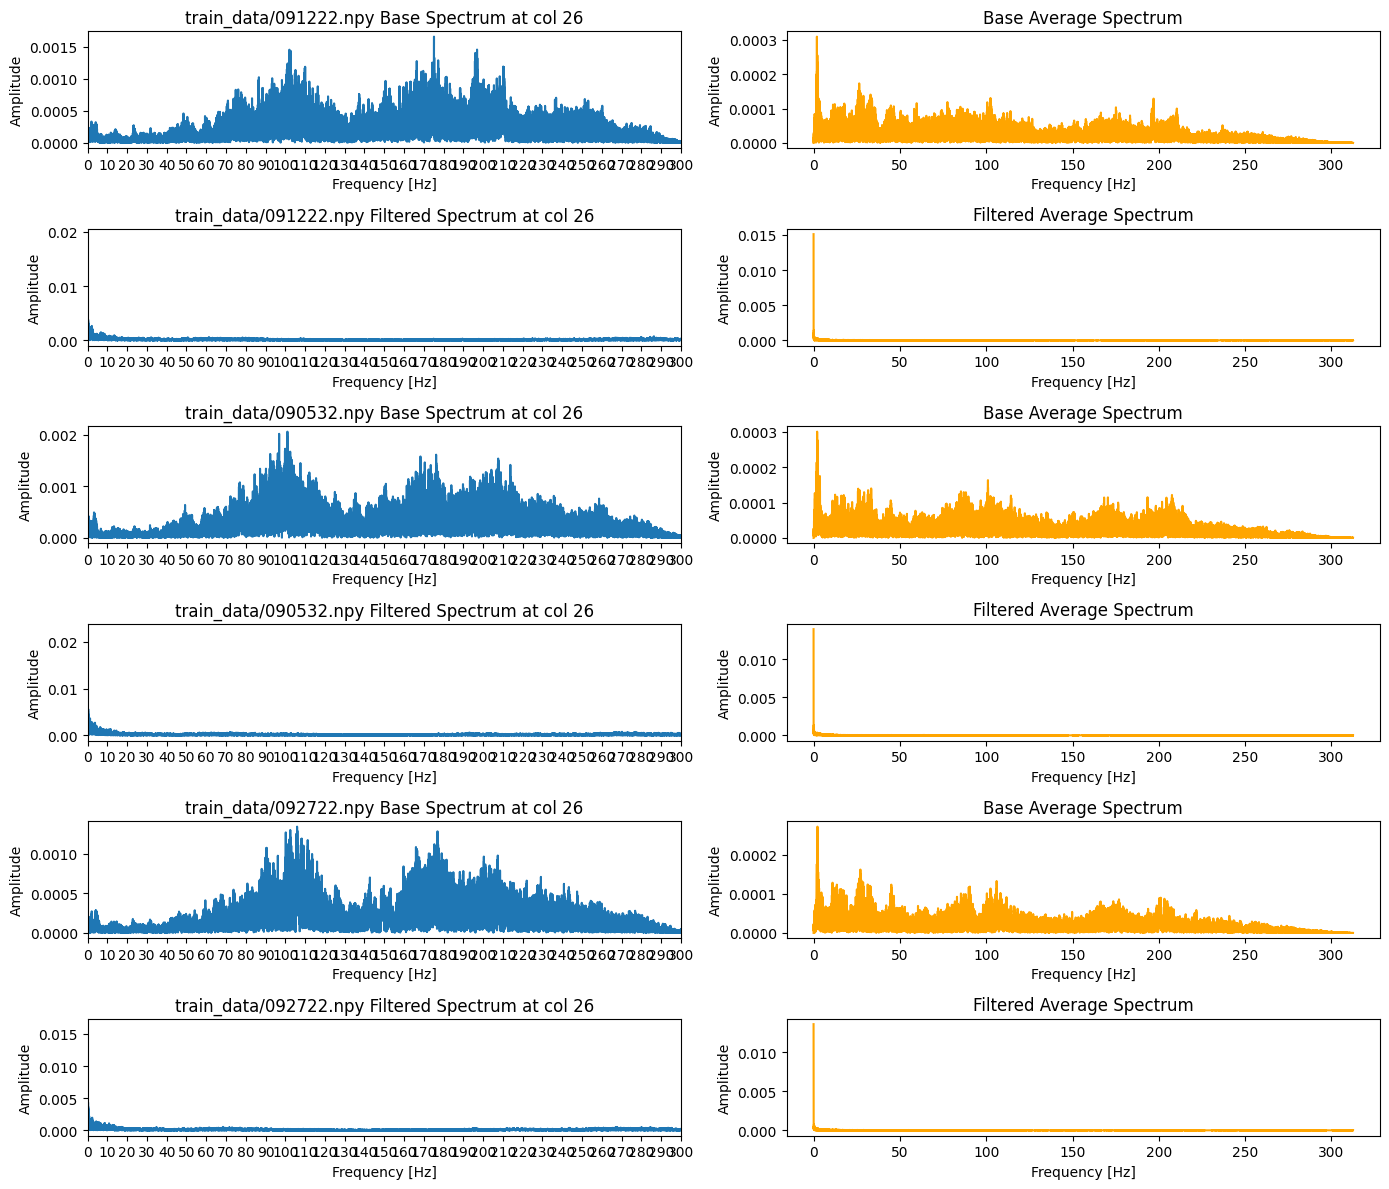

In [4]:
col_id_to_inspect = 26
num_files = len(results_dict)

fig, axes = plt.subplots(num_files*2, 2, figsize=(14, 4 * num_files))

for i, (fname, res) in enumerate(results_dict.items()):
    base_df = res['base_df']
    filtered_df = res['filtered_df']
    
    plot_fft(base_df, col_id_to_inspect, CONFIG['dt'], ax=axes[2*i, 0])
    axes[2*i, 0].set_title(f"{fname} Base Spectrum at col {col_id_to_inspect}")
    plot_average_freq_spectrum(base_df, CONFIG['dt'], ax=axes[2*i, 1])
    axes[2*i, 1].set_title("Base Average Spectrum")


    plot_fft(filtered_df, col_id_to_inspect, CONFIG['dt'], ax=axes[2*i+1, 0])
    axes[2*i+1, 0].set_title(f"{fname} Filtered Spectrum at col {col_id_to_inspect}")
    plot_average_freq_spectrum(filtered_df, CONFIG['dt'], ax=axes[2*i+1, 1])
    axes[2*i+1, 1].set_title("Filtered Average Spectrum")

plt.tight_layout()
plt.show()

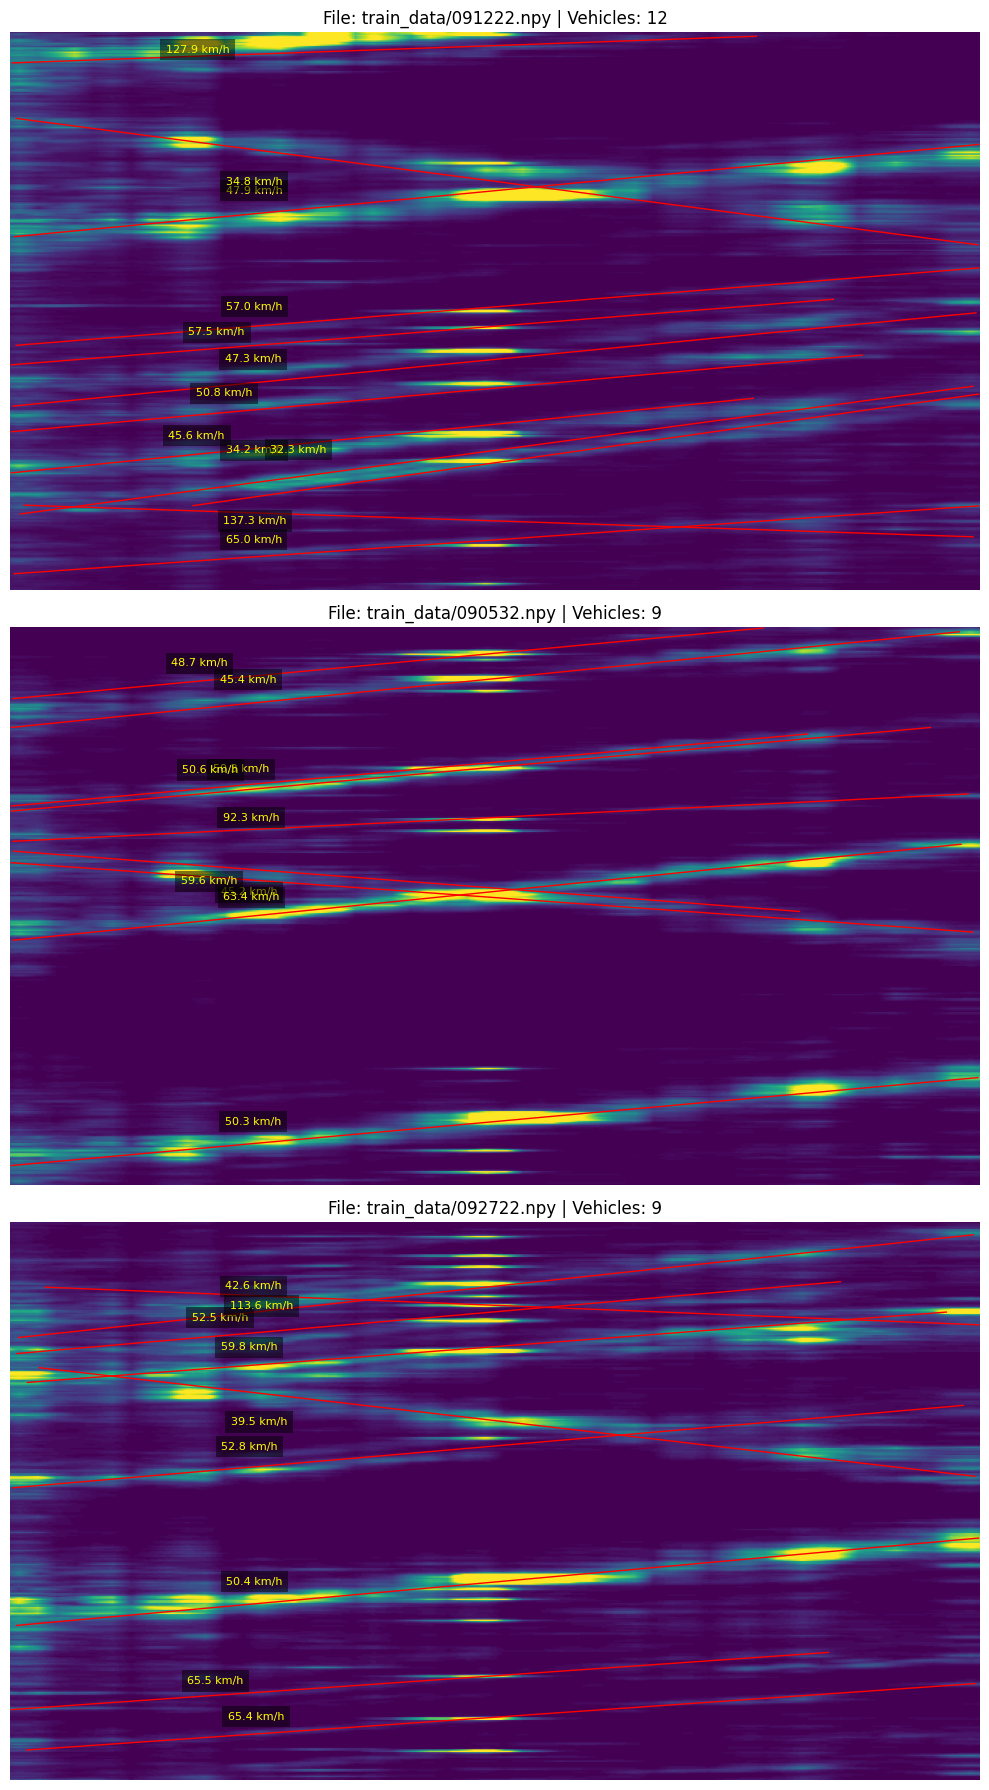

In [5]:
fig, axes = plt.subplots(num_files, 1, figsize=(10, 6 * num_files))

for i, (fname, res) in enumerate(results_dict.items()):

    processed_df = res['processed_df']
    merged_lines = res['merged_lines']
    speeds = res['speeds']

    if len(speeds) > 0:
        mask = (~np.isnan(speeds)) & (speeds <= 160)
        merged_lines = merged_lines[mask]
        speeds = speeds[mask]
    ax = axes[i]
    low, high = np.percentile(processed_df, [3, 99])
    norm = Normalize(vmin=low, vmax=high, clip=True)

    plot_hough_lines(
        processed_df.to_numpy(), merged_lines, speeds, norm,
        title=f"File: {fname} | Vehicles: {len(speeds)}",
        ax=ax
    )

plt.tight_layout()
plt.show()